# **BEACH ENGINEERING**

---

Fernando J. Mendez (fernando.mendez@unican.es)

Full Professor of Coastal Engineering

---

Laura Cagigal (laura.cagigal@unican.es)

Postdoctoral Researcher

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, Univeristy of Cantabria



<img src="../images/Image_1.png" alt="Texto alternativo" width="120">               <img src="../images/Image_2.png" alt="Texto alternativo" width="120"> 

© GeoOcean - University of Cantabria

---

## **Analysis of Global Wave Data**

### <font color='blue'>**Historical Database of Wave and Sea Level Information**</font>

<font color='purple'>**Import Libraries**</font>

In [7]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import os.path as op

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import plotly.express as px
colors = px.colors.qualitative.Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import HTML, display

import seaborn as sns

from windrose import WindroseAxes

from scipy.optimize import root_scalar

sys.path.append(op.join(os.getcwd(), '..'))
from functions.snell_mono import *
from functions.omega import *

<font color='purple'>**Load data**</font>

In [8]:
p_data = op.join(os.getcwd(), '..', 'data', 'CODEC')

In [9]:
# get all stations
data = xr.open_dataset(op.join(p_data, 'CODEC_amax_ERA5_1979_2017_coor_mask_GUM_RPS.nc'))
data['station_name'] = data['station_name'].astype(str)
lon = data.variables['station_x_coordinate'][:]
lat = data.variables['station_y_coordinate'][:]
lon = lon[::10]
lat = lat[::10]

data_cut = data.sel(stations=data.stations[::10])

In [10]:
df_data = data_cut.to_dataframe().reset_index()[['station_name', 'station_x_coordinate', 'station_y_coordinate']]

### <font color='blue'>**Stations Visualization**</font>

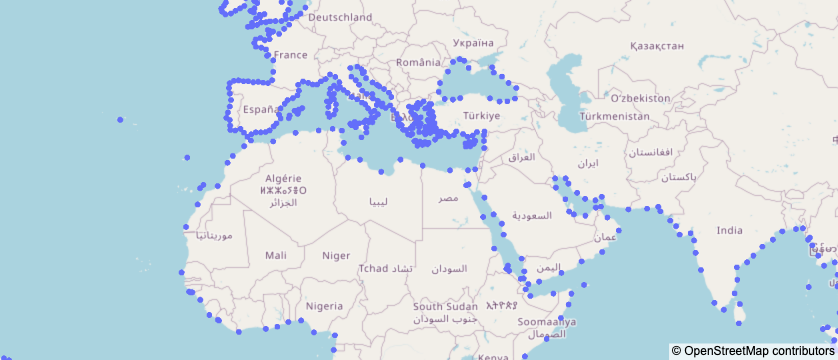

In [13]:
fig = px.scatter_mapbox(
    df_data, 
    lon="station_x_coordinate", 
    lat="station_y_coordinate",
    hover_name='station_name',
    mapbox_style='open-street-map',
    zoom=2
)
fig.update_layout(margin={'r':0, 'l':0, 't': 0, 'b':0})
fig.show()

## **Analysis of temporal series for individual station**

### <font color='blue'>**Station Selection**</font>

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css" integrity="sha512-8u2r+QzZhE9/DV+iFUG5V2F+Qw6u+H3Y1QGyJGj6SN66BU2v4Gl2cDU/KGCD4Zh5a3u2nSKGTEls6m5CIaRqg==" crossorigin="anonymous" referrerpolicy="no-referrer" />

 

<div class="admonition" style="background-color: rgba(0, 0, 255, 0.08); padding: 10px; border-radius: 5px;">
<i class="fa fa-pencil-square-o fa-2x" style="color: #F7C61F;"></i>
<strong>  INPUTS</strong></div>

`lon0:` Longitude value between -176.75.0 & 176.75 (i.e. 24.089) <br>
`lat0:` Latitude value between -90 & 90 (i.e. 34.827)<br>

In [14]:
"Enter longitude value: "
lon0 = -3.88
"Enter latitude value: "
lat0 = 43.49

In [15]:
df_data['distance'] = np.sqrt((df_data['station_x_coordinate'] - lon0)**2 + (df_data['station_y_coordinate'] - lat0)**2)

df_st = df_data.iloc[df_data['distance'].idxmin()]
station_name = np.where(data['station_name'] == df_st.station_name)[0][0]

In [17]:
var = xr.open_dataset(op.join(p_data, 'station' + str(station_name) + '.nc')).squeeze()

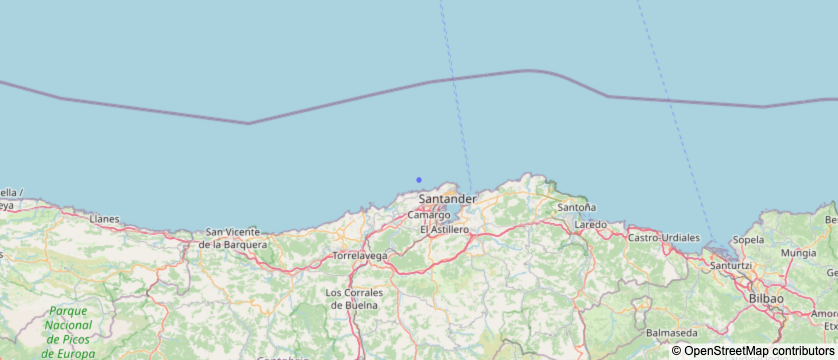

In [18]:
fig = px.scatter_mapbox(
    df_st.to_frame().transpose(), 
    lon="station_x_coordinate", 
    lat="station_y_coordinate",
    mapbox_style='open-street-map',
    zoom=8
)
fig.update_layout(margin={'r':0, 'l':0, 't': 0, 'b':0})

fig.show()

In [19]:
print('Datos disponibles desde {0} hasta {1}'.format(var.time.values[0], var.time.values[-1]))
print('Con resolución de: {0} horas'.format(np.diff(var.time.values)[0]/np.timedelta64(1, 'h')))

Datos disponibles desde 2013-10-01T00:00:00.000000000 hasta 2014-09-30T23:00:00.000000000
Con resolución de: 1.0 horas


### <font color='blue'>**Sea Level, Surge and Tides**</font>

In [11]:
#%matplotlib

Text(0, 0.5, 'MM - Surge [m]')

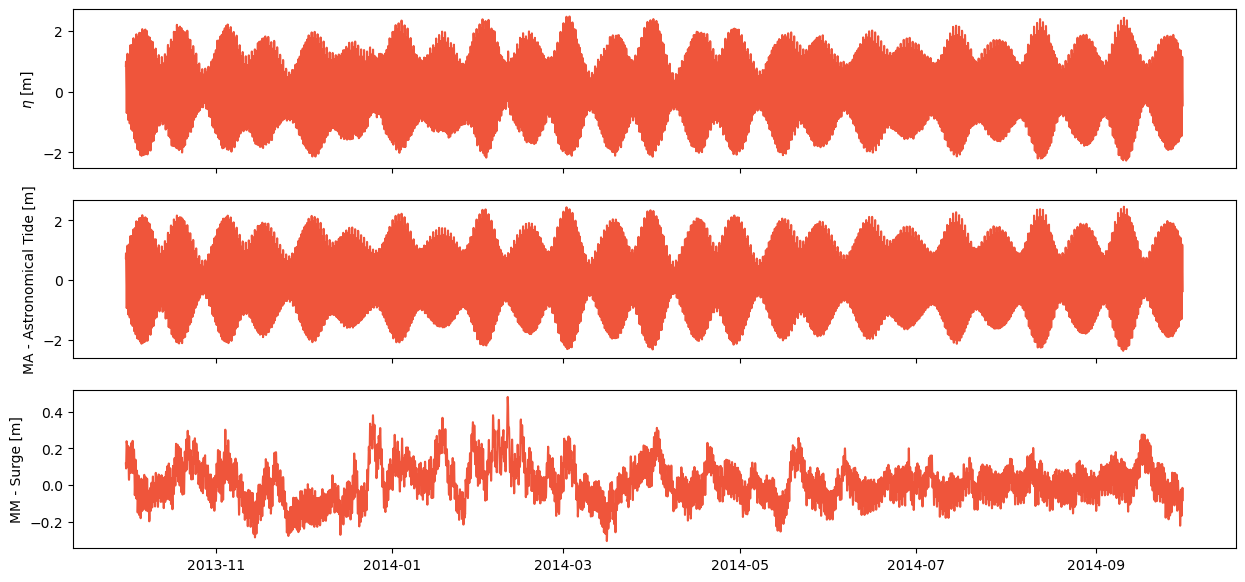

In [20]:
fig, axs = plt.subplots(3, sharex=True, figsize=(15,7))
axs[0].plot(var['time'], var['waterlevel'], c=colors[1])
axs[1].plot(var['time'], var['waterlevel'] - var['surge'], c=colors[1])
axs[2].plot(var['time'], var['surge'], c=colors[1])

axs[0].set_ylabel('$\eta$ [m]')
axs[1].set_ylabel('MA - Astronomical Tide [m]')
axs[2].set_ylabel('MM - Surge [m]')


### <font color='blue'>**Monthly Mean Sea Level**</font>

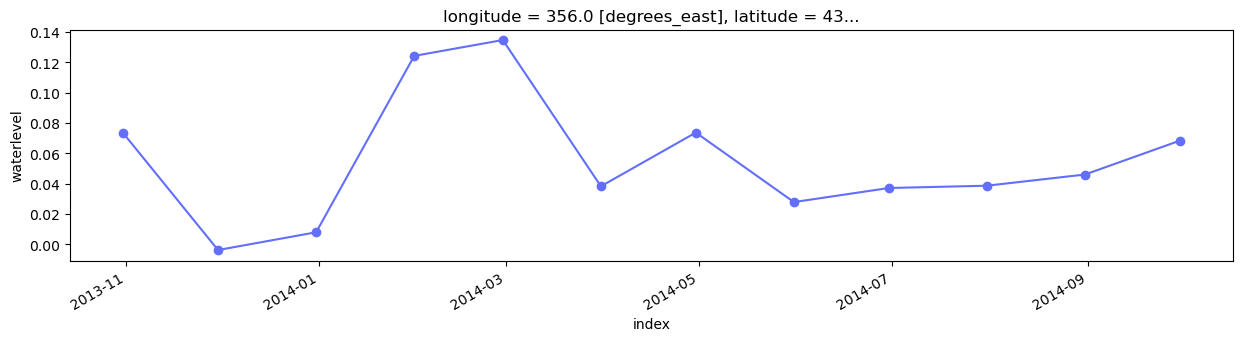

In [21]:
var['index'] = var['time'].values
plt.figure(figsize=(15,3))
var.resample(index='1M').mean().waterlevel.plot(marker='o', c=colors[0])

### <font color='blue'>**Wave Information**</font>

<font color='purple'>**Temporal Series**</font>

Text(0, 0.5, 'Dp [s]')

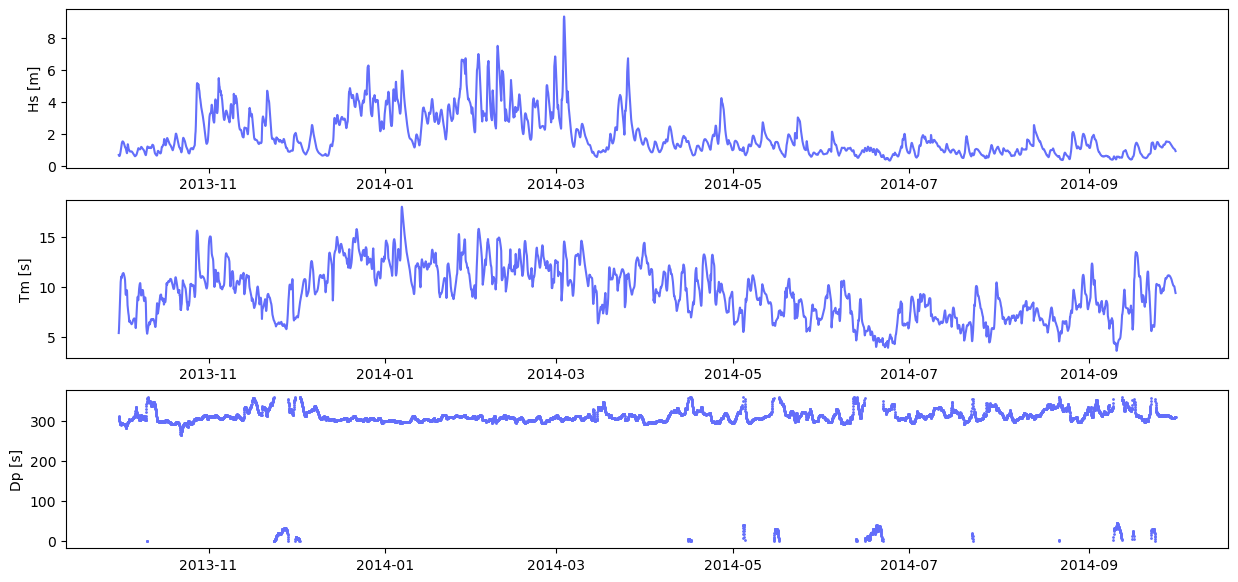

In [22]:
fig, axs = plt.subplots(3, sharex=False, figsize=(15,7))

axs[0].plot(var['time'], var['swh'], c=colors[0])
axs[1].plot(var['time'], var.squeeze()['mwp'], c=colors[0])
axs[2].scatter(var['time'], var.squeeze()['mwd'], c=colors[0], s=1)

axs[0].set_ylabel('Hs [m]')
axs[1].set_ylabel('Tm [s]')
axs[2].set_ylabel('Dp [s]')


<font color='purple'>**Scatter Matrix**</font>

In [23]:
var['E'] = var['swh']**2 * var['mwp']

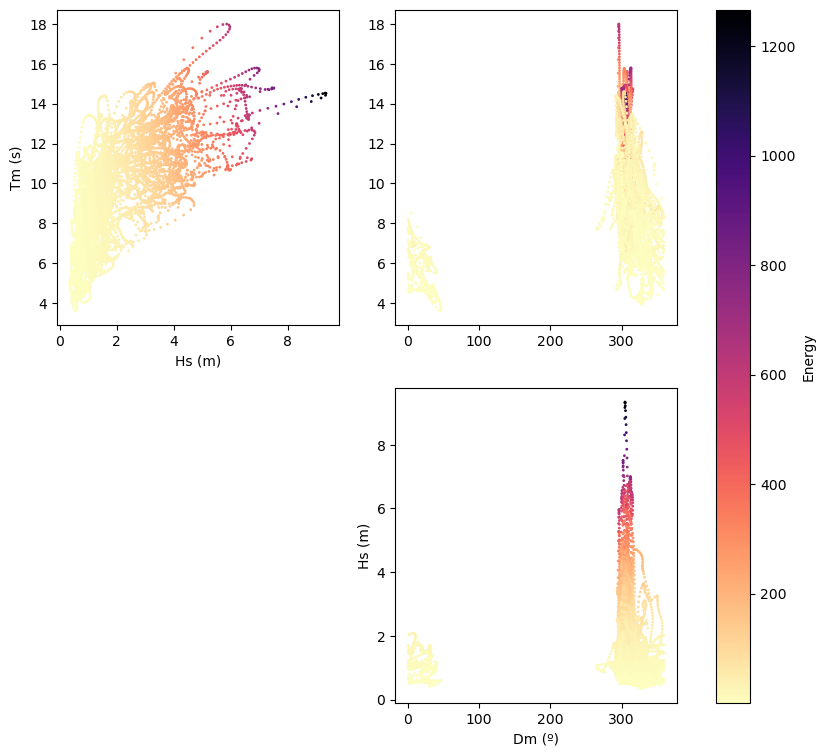

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10,9))
im = axs[0, 0].scatter(var['swh'].values, var['mwp'].values, c=var['E'], cmap='magma_r', s=1)
axs[0, 1].scatter(var['mwd'].values, var['mwp'].values, c=var['E'], cmap='magma_r', s=1)
axs[1, 1].scatter(var['mwd'].values, var['swh'].values, c=var['E'], cmap='magma_r', s=1)
axs[1, 0].axis('off')

axs[0, 0].set_xlabel('Hs (m)')
axs[0, 0].set_ylabel('Tm (s)')

axs[1, 1].set_xlabel('Dm (º)')
axs[1, 1].set_ylabel('Hs (m)')

fig.colorbar(im, ax=axs.ravel().tolist()).set_label('Energy')

<font color='purple'>**Joint Distribution of Hs and Tm**</font>

Joint occurrence of Hs and Tm

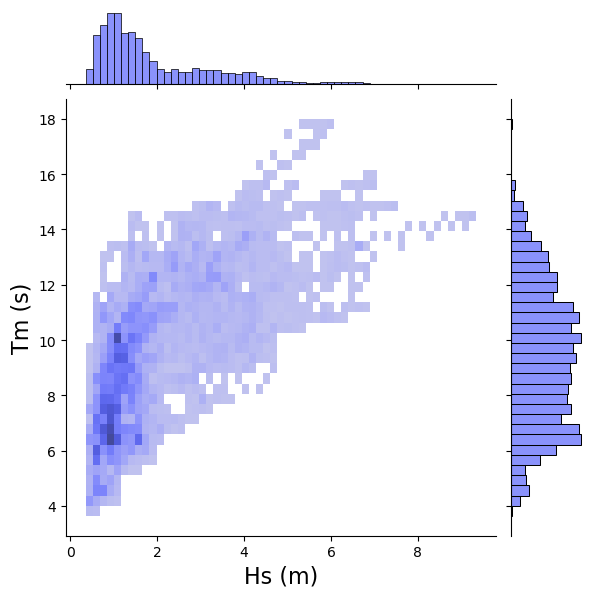

In [25]:
fig = sns.jointplot(x=var['swh'], y=var['mwp'], kind="hist", color=colors[0])
fig.set_axis_labels('Hs (m)', 'Tm (s)', fontsize=16)
plt.show()

<font color='purple'>**Box-plot**</font>

In [26]:
# Dataframe (df) creation
df1 = var['swh'].to_dataframe() # Hs
df1['month'] = df1.index.month # Date
df1['mwp'] = var['mwp'] # Tm
df1['mwd'] = var['mwd'] # Dir

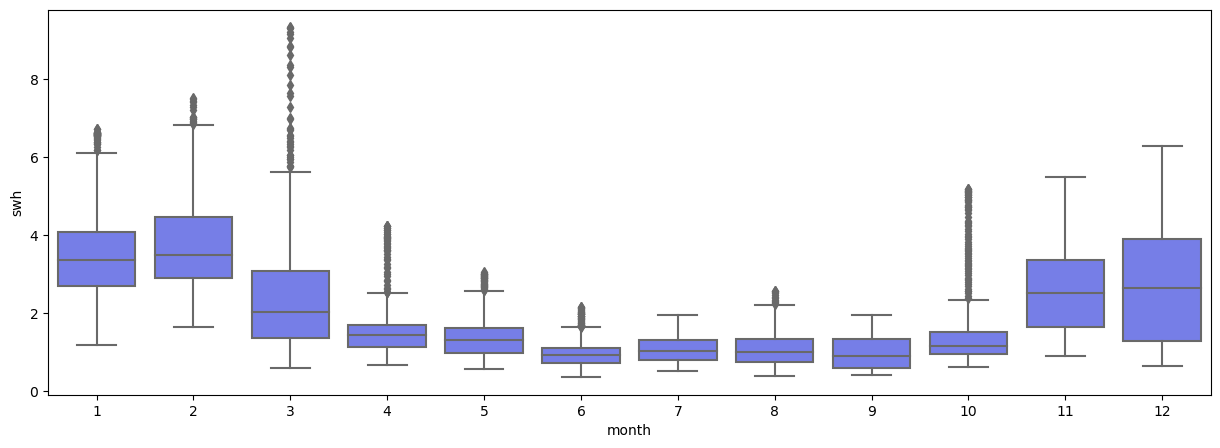

In [27]:
plt.figure(figsize=(15,5))
sns.boxplot(x="month", y="swh", data=df1, palette=[colors[0]])
plt.show()

## **Wave Propagation applying the Snell's law to a target depth**

To obtain the nearshore wave climate, it is necessary to propagate to the target depth.

We will carry out the propagation applying the Snell's law.

<img src="../images/Image_3.png" alt="Texto alternativo" width="600">               <img src="../images/Image_4.png" alt="Texto alternativo" width="200"> 

© Images: Coastal Dynamics Open Textbook,
Authored by Judith Bosboom and Marcel Stive,
ISBN (softback/paperback) 978-94-6366-370-0,
ISBN (e-book) 978-94-6366-371-7,
DOI 10.5074/T.2021.001

4 inputs are required: 

 - Offshore depth (h0)
 - Nearshore depth (h1)
 - Beach orientation (orientation)
 - Beach slope (m)


<font color='purple'>**Offshore depth (h0) and Nearshore depth (h1)**</font>

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css" integrity="sha512-8u2r+QzZhE9/DV+iFUG5V2F+Qw6u+H3Y1QGyJGj6SN66BU2v4Gl2cDU/KGCD4Zh5a3u2nSKGTEls6m5CIaRqg==" crossorigin="anonymous" referrerpolicy="no-referrer" />

 

<div class="admonition" style="background-color: rgba(0, 0, 255, 0.08); padding: 10px; border-radius: 5px;">
<i class="fa fa-pencil-square-o fa-2x" style="color: #F7C61F;"></i>
<strong>  INPUTS</strong></div>

`h0:` Offshore depth <br>
`h1:`Nearshore/target depth<br>

In [28]:
h0 = 40 # offshore depth 
h1 = 10 # nearshore/target depth

<font color='purple'>**Beach slope (m) and beach orientation(orientation)**</font>

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css" integrity="sha512-8u2r+QzZhE9/DV+iFUG5V2F+Qw6u+H3Y1QGyJGj6SN66BU2v4Gl2cDU/KGCD4Zh5a3u2nSKGTEls6m5CIaRqg==" crossorigin="anonymous" referrerpolicy="no-referrer" />

 

<div class="admonition" style="background-color: rgba(0, 0, 255, 0.08); padding: 10px; border-radius: 5px;">
<i class="fa fa-pencil-square-o fa-2x" style="color: #F7C61F;"></i>
<strong>  INPUTS</strong></div>

`m:` Beach slope <br>
`orientation:`Orientation<br>

In [29]:
m = 40/3500 # beach slope
orientation = 327 # beach orientation = angle between the north and the perpendicular to the beach (from north clockwise)

© Image: NAVIONICS

<img src="../images/Image_6.png" alt="Texto alternativo" width="550">               <img src="../images/Image_7.png" alt="Texto alternativo" width="600"> 

© Image (left): NAVIONICS

© Image (right): Coastal Dynamics Open Textbook,
Authored by Judith Bosboom and Marcel Stive,
ISBN (softback/paperback) 978-94-6366-370-0,
ISBN (e-book) 978-94-6366-371-7,
DOI 10.5074/T.2021.001

<font color='purple'>**Relative direction (theta_0) calculation**</font>

Let's calculate the relative direction (theta_0) based on the wave direction (Dir0)

In [30]:
df_0 = theta_0(df1, orientation) # theta_0 calculation

In [31]:
df_0 # check it out

longitude   latitude       swh  month       mwp  \
time                                                                   
2013-10-01 00:00:00      356.0  43.599998  0.701002     10  5.407681   
2013-10-01 01:00:00      356.0  43.599998  0.682105     10  5.559520   
2013-10-01 02:00:00      356.0  43.599998  0.663478     10  5.769555   
2013-10-01 03:00:00      356.0  43.599998  0.648901     10  6.033354   
2013-10-01 04:00:00      356.0  43.599998  0.638912     10  6.349144   
...                        ...        ...       ...    ...       ...   
2014-09-30 19:00:00      356.0  43.599998  1.017050      9  9.627577   
2014-09-30 20:00:00      356.0  43.599998  1.000698      9  9.566723   
2014-09-30 21:00:00      356.0  43.599998  0.983454      9  9.498484   
2014-09-30 22:00:00      356.0  43.599998  0.964724      9  9.439403   
2014-09-30 23:00:00      356.0  43.599998  0.944507      9  9.399522   

                            mwd    theta_0  
time                                        
2013-10-01 00:00:00  312.089722  14.910278  
2013-10-01 01:00:00  310.881165  16.118835  
2013-10-01 02:00:00  308.782654  18.217346  
2013-10-01 03:00:00  306.382019  20.617981  
2013-10-01 04:00:00  304.151672  22.848328  
...                         ...        ...  
2014-09-30 19:00:00  310.337311  16.662689  
2014-09-30 20:00:00  310.474670  16.525330  
2014-09-30 21:00:00  310.612000  16.388000  
2014-09-30 22:00:00  310.655945  16.344055  
2014-09-30 23:00:00  310.595520  16.404480  

[8760 rows x 7 columns]

<font color='purple'>**Snell Propagation**</font>

In [32]:
df_1 = snell_mono_prop(df_0, h0, h1, m, orientation) # The function "snell_mono_prop" that generate the SIMAR dataframe porpagated with Snell monochromatic

In [33]:
df_1 # check it out!

longitude   latitude       swh  month       mwp  \
time                                                                   
2013-10-01 00:00:00      356.0  43.599998  0.701002     10  5.407681   
2013-10-01 01:00:00      356.0  43.599998  0.682105     10  5.559520   
2013-10-01 02:00:00      356.0  43.599998  0.663478     10  5.769555   
2013-10-01 03:00:00      356.0  43.599998  0.648901     10  6.033354   
2013-10-01 04:00:00      356.0  43.599998  0.638912     10  6.349144   
...                        ...        ...       ...    ...       ...   
2014-09-30 19:00:00      356.0  43.599998  1.017050      9  9.627577   
2014-09-30 20:00:00      356.0  43.599998  1.000698      9  9.566723   
2014-09-30 21:00:00      356.0  43.599998  0.983454      9  9.498484   
2014-09-30 22:00:00      356.0  43.599998  0.964724      9  9.439403   
2014-09-30 23:00:00      356.0  43.599998  0.944507      9  9.399522   

                            mwd    theta_0        H1   H1_Goda          L0  \
time                                                                         
2013-10-01 00:00:00  312.089722  14.910278  0.644764  0.644764   45.657410   
2013-10-01 01:00:00  310.881165  16.118835  0.624665  0.624665   48.257385   
2013-10-01 02:00:00  308.782654  18.217346  0.604207  0.604207   51.972519   
2013-10-01 03:00:00  306.382019  20.617981  0.587474  0.587474   56.833809   
2013-10-01 04:00:00  304.151672  22.848328  0.575321  0.575321   62.938957   
...                         ...        ...       ...       ...         ...   
2014-09-30 19:00:00  310.337311  16.662689  0.951845  0.951845  144.718201   
2014-09-30 20:00:00  310.474670  16.525330  0.936145  0.936145  142.894516   
2014-09-30 21:00:00  310.612000  16.388000  0.919487  0.919487  140.863251   
2014-09-30 22:00:00  310.655945  16.344055  0.901371  0.901371  139.116333   
2014-09-30 23:00:00  310.595520  16.404480  0.881989  0.881989  137.943314   

                       theta_1        Dir1  
time                                        
2013-10-01 00:00:00  13.510616  313.489384  
2013-10-01 01:00:00  14.408539  312.591461  
2013-10-01 02:00:00  15.964560  311.035440  
2013-10-01 03:00:00  17.601877  309.398123  
2013-10-01 04:00:00  18.888023  308.111977  
...                        ...         ...  
2014-09-30 19:00:00  10.631080  316.368920  
2014-09-30 20:00:00  10.580635  316.419365  
2014-09-30 21:00:00  10.534795  316.465205  
2014-09-30 22:00:00  10.542955  316.457045  
2014-09-30 23:00:00  10.605970  316.394030  

[8760 rows x 12 columns]

## **Wave Propagation applying the Snell's law to the breaking depth**

<font color='purple'>**Breaking depth calculation (hb)**</font>

In [34]:
# BreakingGoda Function
def BreakingGoda(T, hb, m):
    return 0.17 * (1.56 * T**2) * (1 - np.exp(-1.5 * np.pi * hb / (1.56 * T**2) * (1 + 15 * m**(4/3))))

# BreakingStartGoda function
def BreakingStartGoda(H0, T, Teta0, hb, m):
    g = 9.81
    T_rad = np.deg2rad(Teta0)
    asin_arg = (g * hb)**0.5 * np.sin(T_rad) / (g * T / (2 * np.pi))
    return H0 * (np.cos(T_rad) / np.cos(np.arcsin(asin_arg)))**0.5 * ((g * T / (4 * np.pi)) / (g * hb)**0.5)**0.5 - BreakingGoda(T, hb, m)


# hb calculation fuction
def hb_calculation(H0, T, Teta0, m):
    
    # Definir una función anónima para la raíz
    root_func = lambda hb: BreakingStartGoda(H0, T, Teta0, hb, m)
    
    # Encontrar la raíz (valor de hb) usando root_scalar
    result = root_scalar(root_func, bracket=[0, 15])  # Ajusta el intervalo [0, 15] según tus necesidades
    
    # Return hb
    return result.root

In [35]:
# Let's assume you have a DataFrame named df with columns 'Hs0', 'Tp', and 'theta_0' and a constant value m. 
# Create a new column 'hb' in the DataFrame using the function 'hb_calculation'

df_1['hb'] = df_1.apply(lambda row: hb_calculation(row['swh'], row['mwp'], row['theta_0'], m), axis=1)

In [36]:
df_1['hb'] = df_1.apply(lambda row: 0.1 if row['swh'] < 0.1 else row['hb'], axis=1) # Replace hb values when Hs0<0.1 m

In [37]:
df_1 # check it out!

longitude   latitude       swh  month       mwp  \
time                                                                   
2013-10-01 00:00:00      356.0  43.599998  0.701002     10  5.407681   
2013-10-01 01:00:00      356.0  43.599998  0.682105     10  5.559520   
2013-10-01 02:00:00      356.0  43.599998  0.663478     10  5.769555   
2013-10-01 03:00:00      356.0  43.599998  0.648901     10  6.033354   
2013-10-01 04:00:00      356.0  43.599998  0.638912     10  6.349144   
...                        ...        ...       ...    ...       ...   
2014-09-30 19:00:00      356.0  43.599998  1.017050      9  9.627577   
2014-09-30 20:00:00      356.0  43.599998  1.000698      9  9.566723   
2014-09-30 21:00:00      356.0  43.599998  0.983454      9  9.498484   
2014-09-30 22:00:00      356.0  43.599998  0.964724      9  9.439403   
2014-09-30 23:00:00      356.0  43.599998  0.944507      9  9.399522   

                            mwd    theta_0        H1   H1_Goda          L0  \
time                                                                         
2013-10-01 00:00:00  312.089722  14.910278  0.644764  0.644764   45.657410   
2013-10-01 01:00:00  310.881165  16.118835  0.624665  0.624665   48.257385   
2013-10-01 02:00:00  308.782654  18.217346  0.604207  0.604207   51.972519   
2013-10-01 03:00:00  306.382019  20.617981  0.587474  0.587474   56.833809   
2013-10-01 04:00:00  304.151672  22.848328  0.575321  0.575321   62.938957   
...                         ...        ...       ...       ...         ...   
2014-09-30 19:00:00  310.337311  16.662689  0.951845  0.951845  144.718201   
2014-09-30 20:00:00  310.474670  16.525330  0.936145  0.936145  142.894516   
2014-09-30 21:00:00  310.612000  16.388000  0.919487  0.919487  140.863251   
2014-09-30 22:00:00  310.655945  16.344055  0.901371  0.901371  139.116333   
2014-09-30 23:00:00  310.595520  16.404480  0.881989  0.881989  137.943314   

                       theta_1        Dir1        hb  
time                                                  
2013-10-01 00:00:00  13.510616  313.489384  1.013658  
2013-10-01 01:00:00  14.408539  312.591461  0.997657  
2013-10-01 02:00:00  15.964560  311.035440  0.982885  
2013-10-01 03:00:00  17.601877  309.398123  0.974212  
2013-10-01 04:00:00  18.888023  308.111977  0.973044  
...                        ...         ...       ...  
2014-09-30 19:00:00  10.631080  316.368920  1.677655  
2014-09-30 20:00:00  10.580635  316.419365  1.652185  
2014-09-30 21:00:00  10.534795  316.465205  1.625054  
2014-09-30 22:00:00  10.542955  316.457045  1.596188  
2014-09-30 23:00:00  10.605970  316.394030  1.566150  

[8760 rows x 13 columns]

<font color='purple'>**Breaking wave height calculation (H1_Goda_b)**</font>

In [38]:
df_1 = snell_mono_prop_breaking(df_1, h0, m, orientation)

In [39]:
df_1 # check it out!

longitude   latitude       swh  month       mwp  \
time                                                                   
2013-10-01 00:00:00      356.0  43.599998  0.701002     10  5.407681   
2013-10-01 01:00:00      356.0  43.599998  0.682105     10  5.559520   
2013-10-01 02:00:00      356.0  43.599998  0.663478     10  5.769555   
2013-10-01 03:00:00      356.0  43.599998  0.648901     10  6.033354   
2013-10-01 04:00:00      356.0  43.599998  0.638912     10  6.349144   
...                        ...        ...       ...    ...       ...   
2014-09-30 19:00:00      356.0  43.599998  1.017050      9  9.627577   
2014-09-30 20:00:00      356.0  43.599998  1.000698      9  9.566723   
2014-09-30 21:00:00      356.0  43.599998  0.983454      9  9.498484   
2014-09-30 22:00:00      356.0  43.599998  0.964724      9  9.439403   
2014-09-30 23:00:00      356.0  43.599998  0.944507      9  9.399522   

                            mwd    theta_0        H1   H1_Goda          L0  \
time                                                                         
2013-10-01 00:00:00  312.089722  14.910278  0.644764  0.644764   45.657410   
2013-10-01 01:00:00  310.881165  16.118835  0.624665  0.624665   48.257385   
2013-10-01 02:00:00  308.782654  18.217346  0.604207  0.604207   51.972519   
2013-10-01 03:00:00  306.382019  20.617981  0.587474  0.587474   56.833809   
2013-10-01 04:00:00  304.151672  22.848328  0.575321  0.575321   62.938957   
...                         ...        ...       ...       ...         ...   
2014-09-30 19:00:00  310.337311  16.662689  0.951845  0.951845  144.718201   
2014-09-30 20:00:00  310.474670  16.525330  0.936145  0.936145  142.894516   
2014-09-30 21:00:00  310.612000  16.388000  0.919487  0.919487  140.863251   
2014-09-30 22:00:00  310.655945  16.344055  0.901371  0.901371  139.116333   
2014-09-30 23:00:00  310.595520  16.404480  0.881989  0.881989  137.943314   

                       theta_1        Dir1        hb      H1_b  H1_Goda_b  \
time                                                                        
2013-10-01 00:00:00  13.510616  313.489384  1.013658  0.827544   0.799195   
2013-10-01 01:00:00  14.408539  312.591461  0.997657  0.815244   0.789473   
2013-10-01 02:00:00  15.964560  311.035440  0.982885  0.804529   0.781089   
2013-10-01 03:00:00  17.601877  309.398123  0.974212  0.798305   0.777503   
2013-10-01 04:00:00  18.888023  308.111977  0.973044  0.798522   0.779720   
...                        ...         ...       ...       ...        ...   
2014-09-30 19:00:00  10.631080  316.368920  1.677655  1.346546   1.346546   
2014-09-30 20:00:00  10.580635  316.419365  1.652185  1.327440   1.327440   
2014-09-30 21:00:00  10.534795  316.465205  1.625054  1.307087   1.307087   
2014-09-30 22:00:00  10.542955  316.457045  1.596188  1.285294   1.285294   
2014-09-30 23:00:00  10.605970  316.394030  1.566150  1.261837   1.261837   

                     theta_1_b      Dir1_b  
time                                        
2013-10-01 00:00:00   5.385970  321.614030  
2013-10-01 01:00:00   5.618124  321.381876  
2013-10-01 02:00:00   6.063954  320.936046  
2013-10-01 03:00:00   6.518267  320.481733  
2013-10-01 04:00:00   6.842306  320.157694  
...                        ...         ...  
2014-09-30 19:00:00   4.617023  322.382977  
2014-09-30 20:00:00   4.565005  322.434995  
2014-09-30 21:00:00   4.513165  322.486835  
2014-09-30 22:00:00   4.481025  322.518975  
2014-09-30 23:00:00   4.468574  322.531426  

[8760 rows x 17 columns]

## **PLOTS: OFFSHORE-NEARSHORE**

<font color='purple'>**Series**</font>

(0.0, 360.0)

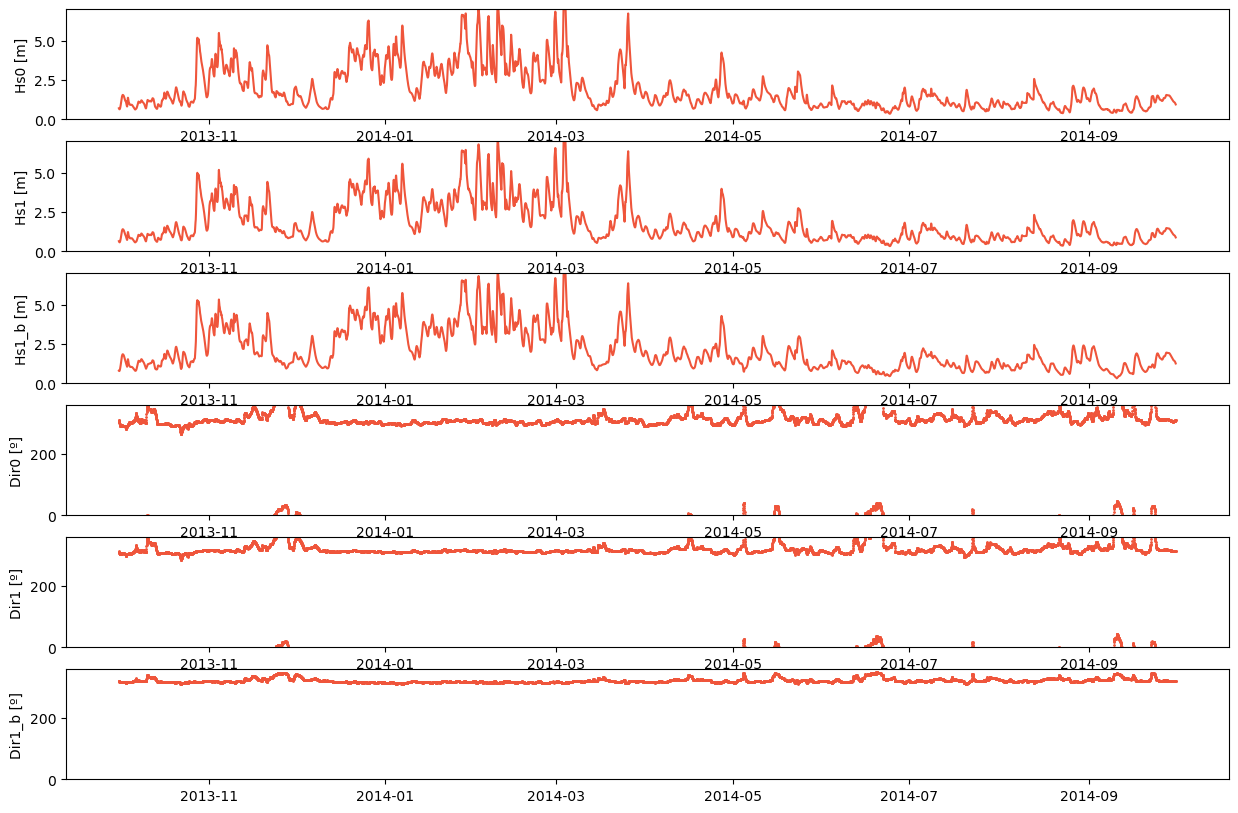

In [40]:
fig, axs = plt.subplots(6, sharex=False, figsize=(15,10))

axs[0].plot(df_1.index, df_1['swh'], c=colors[1])
axs[1].plot(df_1.index, df_1['H1_Goda'], c=colors[1])
axs[2].plot(df_1.index, df_1['H1_Goda_b'], c=colors[1])
axs[3].scatter(df_1.index, df_1['mwd'], c=colors[1], s=1)
axs[4].scatter(df_1.index, df_1['Dir1'], c=colors[1], s=1)
axs[5].scatter(df_1.index, df_1['Dir1_b'], c=colors[1], s=1)

axs[0].set_ylabel('Hs0 [m]')
axs[1].set_ylabel('Hs1 [m]')
axs[2].set_ylabel('Hs1_b [m]')
axs[3].set_ylabel('Dir0 [º]')
axs[4].set_ylabel('Dir1 [º]')
axs[5].set_ylabel('Dir1_b [º]')

axs[0].set_ylim(0,7)
axs[1].set_ylim(0,7)
axs[2].set_ylim(0,7)
axs[3].set_ylim(0,360)
axs[4].set_ylim(0,360)
axs[5].set_ylim(0,360)



<font color='purple'>**Histogram 1D**</font>

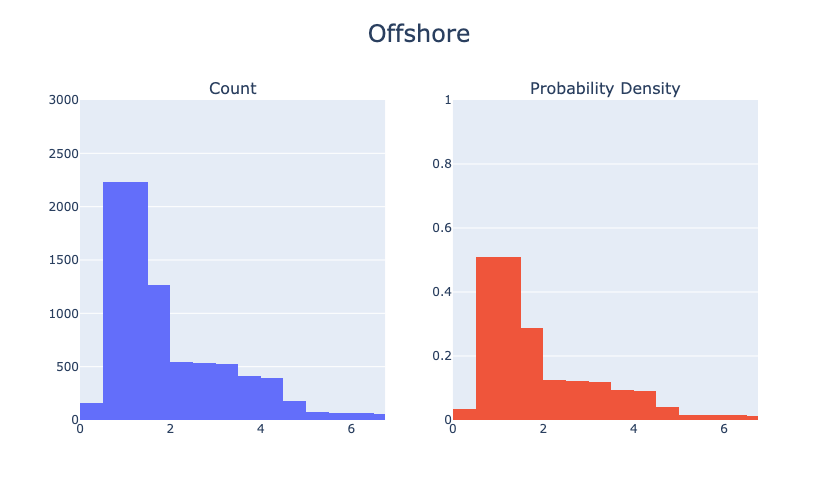

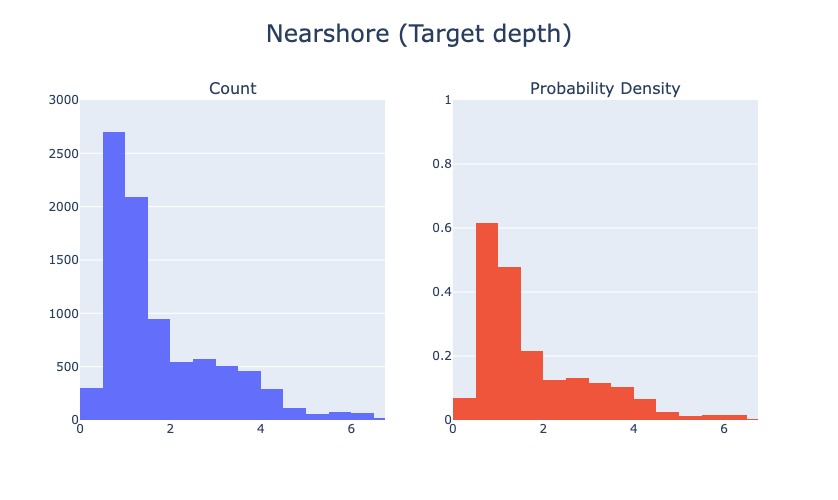

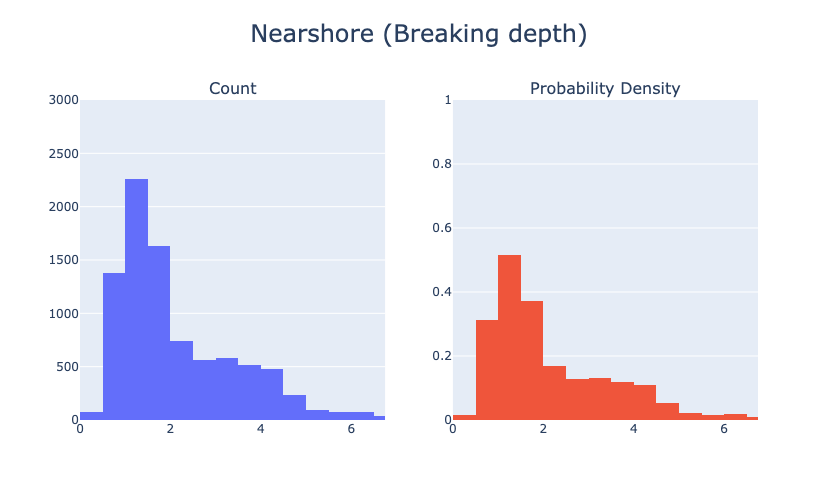

In [41]:
# OFFSHORE
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Count', 'Probability Density'], 
)
fig.append_trace(
    go.Histogram(x = df_1['swh'], nbinsx = 30), 
    1, 1,
)
fig.append_trace( 
    go.Histogram(x = df_1['swh'], nbinsx = 30, histnorm='probability density'), 
    1, 2
)
fig.update_layout(
    title={
        'text': 'Offshore',
        'x': 0.5,  # Alinea el título horizontalmente en el centro
        'xanchor': 'center',
        'y': 0.95,  # Ajusta la posición vertical del título (mayor valor lo sube)
        'yanchor': 'top',
        'font': {'size': 24}  # Ajusta el tamaño del título

    },
    showlegend=False,
    height=500,  # Ajusta la altura deseada
    width=1200,   # Ajusta el ancho deseado
)

fig.update_xaxes(range=[0, 6.75], row=1, col=1)
fig.update_yaxes(range=[0, 3000], row=1, col=1)
fig.update_xaxes(range=[0, 6.75], row=1, col=2)
fig.update_yaxes(range=[0, 1], row=1, col=2)


fig.show()



# NEARSHORE (target depth)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Count', 'Probability Density'], 
)
fig.append_trace(
    go.Histogram(x = df_1['H1_Goda'], nbinsx = 30), 
    1, 1,
)
fig.append_trace( 
    go.Histogram(x = df_1['H1_Goda'], nbinsx = 30, histnorm='probability density'), 
    1, 2
)
fig.update_layout(
    title={
        'text': 'Nearshore (Target depth)',
        'x': 0.5,  
        'xanchor': 'center',
        'y': 0.95,  
        'yanchor': 'top',
        'font': {'size': 24}  

    },
    showlegend=False,
    height=500, 
    width=1200,  
)

fig.update_xaxes(range=[0, 6.75], row=1, col=1)
fig.update_yaxes(range=[0, 3000], row=1, col=1)
fig.update_xaxes(range=[0, 6.75], row=1, col=2)
fig.update_yaxes(range=[0, 1], row=1, col=2)

fig.show()



# NEARSHORE (breaking depth)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Count', 'Probability Density'], 
)
fig.append_trace(
    go.Histogram(x = df_1['H1_Goda_b'], nbinsx = 30), 
    1, 1,
)
fig.append_trace( 
    go.Histogram(x = df_1['H1_Goda_b'], nbinsx = 30, histnorm='probability density'), 
    1, 2
)
fig.update_layout(
    title={
        'text': 'Nearshore (Breaking depth)',
        'x': 0.5,  
        'xanchor': 'center',
        'y': 0.95,  
        'yanchor': 'top',
        'font': {'size': 24}  

    },
    showlegend=False,
    height=500,  
    width=1200,   
)

fig.update_xaxes(range=[0, 6.75], row=1, col=1)
fig.update_yaxes(range=[0, 3000], row=1, col=1)
fig.update_xaxes(range=[0, 6.75], row=1, col=2)
fig.update_yaxes(range=[0, 1], row=1, col=2)

fig.show()

<font color='purple'>**Wave Rose**</font>

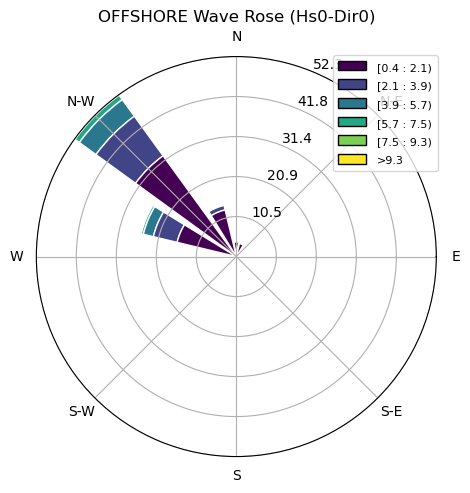

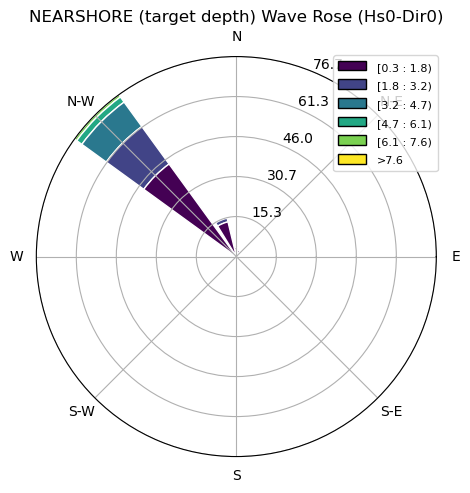

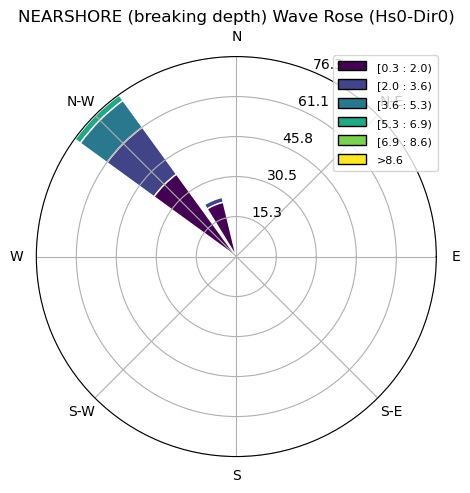

In [42]:
# OFFSHORE
fig1 = plt.figure(figsize=(5, 5))

ax1 = WindroseAxes.from_ax(fig=fig1)
ax1.bar(
    df_1['mwd'],
    df_1['swh'],
    normed=True,
    opening=0.8,
    edgecolor='white',
    nsector=16,  
)
ax1.set_legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title('OFFSHORE Wave Rose (Hs0-Dir0)')

plt.show(fig1)



# NEARSHORE (target depth)
fig1 = plt.figure(figsize=(5, 5))

ax1 = WindroseAxes.from_ax(fig=fig1)
ax1.bar(
    df_1['Dir1'],
    df_1['H1_Goda'],
    normed=True,
    opening=0.8,
    edgecolor='white',
    nsector=16,
)
ax1.set_legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title('NEARSHORE (target depth) Wave Rose (Hs0-Dir0)')

plt.show(fig1)




# NEARSHORE (breaking depth)
fig1 = plt.figure(figsize=(5, 5))

ax1 = WindroseAxes.from_ax(fig=fig1)
ax1.bar(
    df_1['Dir1_b'],
    df_1['H1_Goda_b'],
    normed=True,
    opening=0.8,
    edgecolor='white',
    nsector=16,
)
ax1.set_legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.set_title('NEARSHORE (breaking depth) Wave Rose (Hs0-Dir0)')

plt.show(fig1)


<font color='purple'>**Scatter Plot on polar axis**</font>

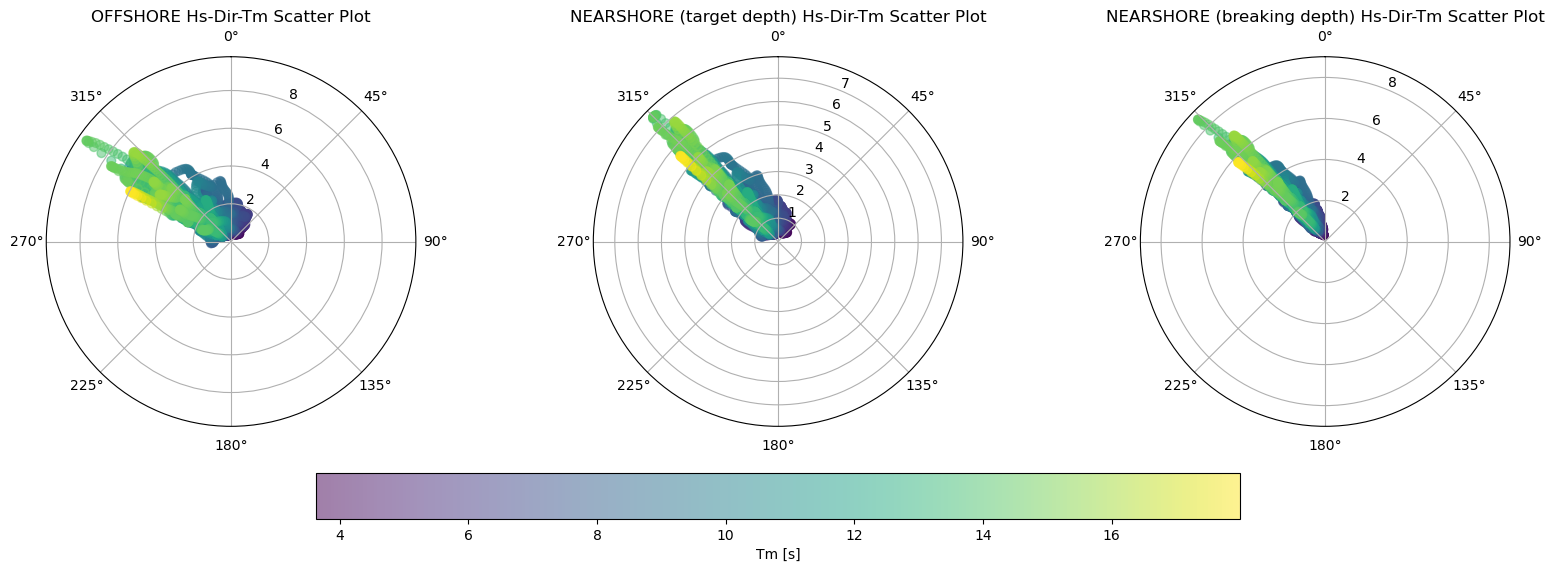

In [43]:
# OFFSHORE
# Compute areas and colors
fig = plt.figure(figsize=[20,6])
ax = fig.add_subplot(1,3,1,projection='polar')
c = ax.scatter(np.deg2rad(df_1.sort_values(by='mwp')["mwd"]), df_1.sort_values(by='mwp')["swh"], c=df_1.sort_values(by='mwp')["mwp"], s=40, cmap='viridis', alpha=0.5)
ax.set_title('OFFSHORE Hs-Dir-Tm Scatter Plot')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)



# NEARSHORE (TARGET DEPTH)
# Compute areas and colors
#fig = plt.figure()
ax2 = fig.add_subplot(1,3,2,projection='polar')
c = ax2.scatter(np.deg2rad(df_1.sort_values(by='mwp')["Dir1"]), df_1.sort_values(by='mwp')["H1_Goda"], c=df_1.sort_values(by='mwp')["mwp"], s=40, cmap='viridis', alpha=0.5)
ax2.set_title('NEARSHORE (target depth) Hs-Dir-Tm Scatter Plot')
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)




# NEARSHORE (BREAKING DEPTH)
# Compute areas and colors
#fig = plt.figure()
ax3 = fig.add_subplot(1,3,3,projection='polar')
c = ax3.scatter(np.deg2rad(df_1.sort_values(by='mwp')["Dir1_b"]), df_1.sort_values(by='mwp')["H1_Goda_b"], c=df_1.sort_values(by='mwp')["mwp"], s=40, cmap='viridis', alpha=0.5)
ax3.set_title('NEARSHORE (breaking depth) Hs-Dir-Tm Scatter Plot')
ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)

# Colorbar
colorbar = plt.colorbar(c, ax=[ax,ax2,ax3], pad=0.1, orientation='horizontal', fraction=.1)
colorbar.set_label('Tm [s]') 

plt.show()

<font color='purple'>**Joint Distribution of Hs and Tm (Histogram 2D)**</font>

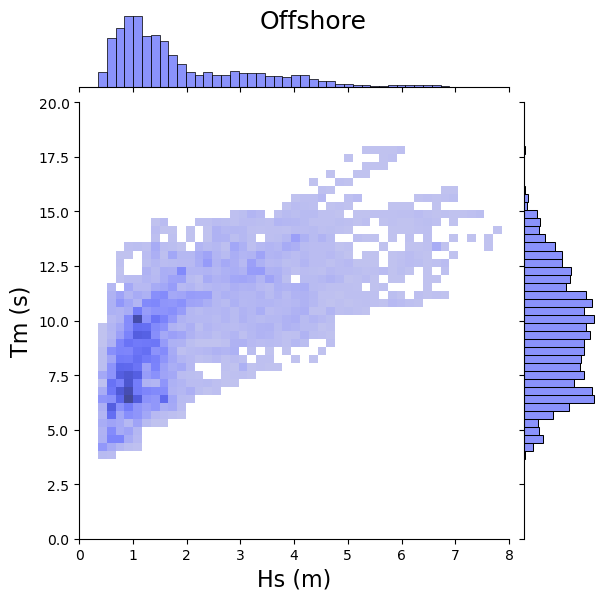

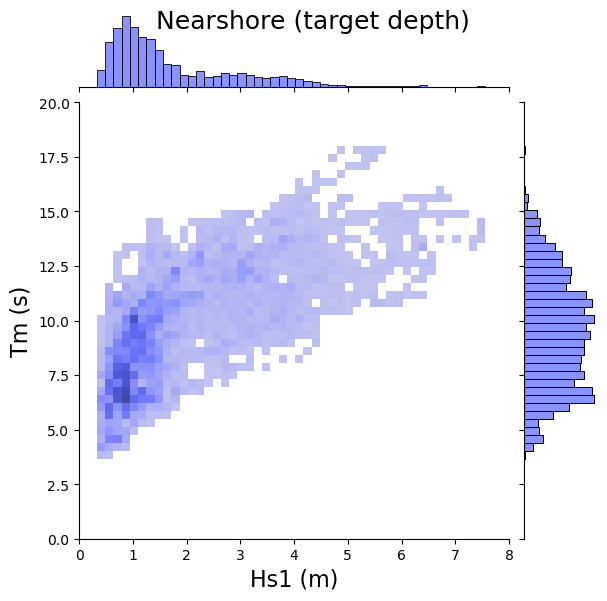

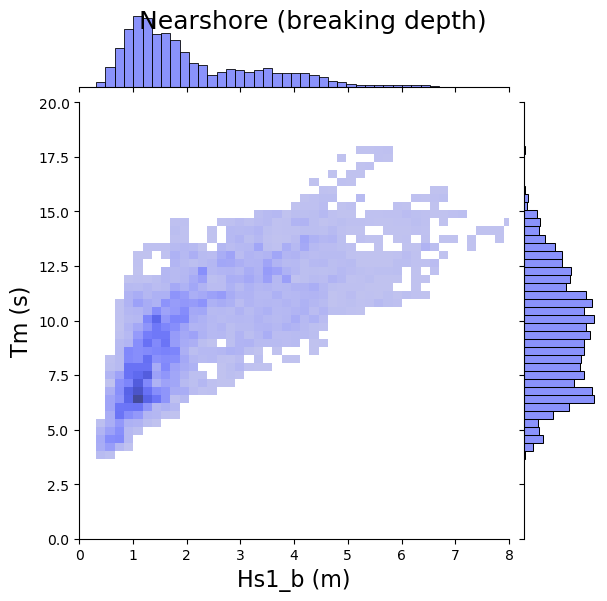

In [44]:
# OFFSHORE
fig = sns.jointplot(x=var['swh'], y=var['mwp'], kind="hist", color=colors[0])
fig.set_axis_labels('Hs (m)', 'Tm (s)', fontsize=16)
fig.fig.suptitle("Offshore", fontsize=18)
fig.ax_joint.set_xlim(0, 8)  
fig.ax_joint.set_ylim(0, 20)  
plt.show()

# NEARSHORE (target depth)
fig = sns.jointplot(x=df_1['H1_Goda'], y=df_1['mwp'], kind="hist", color=colors[0])
fig.set_axis_labels('Hs1 (m)', 'Tm (s)', fontsize=16)
fig.ax_joint.set_xlim(0, 8)  
fig.ax_joint.set_ylim(0, 20)  
fig.fig.suptitle("Nearshore (target depth)", fontsize=18)
plt.show()

# NEARSHORE (breaking depth)
fig = sns.jointplot(x=df_1['H1_Goda_b'], y=df_1['mwp'], kind="hist", color=colors[0])
fig.set_axis_labels('Hs1_b (m)', 'Tm (s)', fontsize=16)
fig.ax_joint.set_xlim(0, 8)  
fig.ax_joint.set_ylim(0, 20)  
fig.fig.suptitle("Nearshore (breaking depth)", fontsize=18)
plt.show()



## **BEACH MORPHODYNAMICS**

### <font color='blue'>**MORPHODYNAMIC STATES**</font>

<font color='purple'>**Beach State**</font>

<img src="../images/Image_8.png" alt="Texto alternativo" width="800"> 

© Castelle B and Masselink G (2023). Morphodynamics of wave-dominated beaches. Cambridge Prisms: Coastal Futures, 1, e1, 1–13

<font color='purple'>**Daily resample**</font>

In [45]:
#df_1.index = pd.to_datetime(df_1.index, format='%Y %m %d %H')
df_1 = df_1.resample('D').mean()

<font color='purple'>**Fall velocity calculation**</font>

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css" integrity="sha512-8u2r+QzZhE9/DV+iFUG5V2F+Qw6u+H3Y1QGyJGj6SN66BU2v4Gl2cDU/KGCD4Zh5a3u2nSKGTEls6m5CIaRqg==" crossorigin="anonymous" referrerpolicy="no-referrer" />

 

<div class="admonition" style="background-color: rgba(0, 0, 255, 0.08); padding: 10px; border-radius: 5px;">
<i class="fa fa-pencil-square-o fa-2x" style="color: #F7C61F;"></i>
<strong>  INPUTS</strong></div>

`D50:` Grain sizes of the beaches [m] <br>
`Tw:` Water temperature in degrees Celsisus [º]<br>

In [46]:
# INPUTS
D50 = 0.00028  # [m]
Tw = 16 # Water temperature in degrees Celsisus [º]

In [47]:
w = fallvelocity(D50, Tw)
print(f"Fall velocity: {w} m/s")

Fall velocity: 0.03464781886279453 m/s


<font color='purple'>**Omega calculation (Ω)**</font>

In [48]:
def omega_calculation(df, w):
    
    omega=df["H1_Goda_b"]/(w*df["mwp"])
    df['Omega'] = omega     
    return(df)

In [49]:
df_1_omega = omega_calculation(df_1,w) # check it out!

In [50]:
# Replace NaN in a Column with the previous value
df_1_omega['Omega'].fillna(method='ffill', inplace=True)

In [51]:
# Check if your Column has NaN
tiene_nans = df_1_omega["Omega"].isna().any()
tiene_nans

False

Relationships between change in beach state (and bar migration, shoreline change and cusp development) and morphodynamic disequilibrium and incident wave thrust, with arrow length proportional to the rate of change. 

<img src="../images/Image_9.png" alt="Texto alternativo" width="400"> 

@ Castelle B and Masselink G
(2023). Morphodynamics of wave-dominated
beaches. Cambridge Prisms: Coastal Futures,
1, e1, 1–13

<font color='purple'>**Response factor calculation (Splinter et. al (2014))**</font>

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.3/css/all.min.css" integrity="sha512-8u2r+QzZhE9/DV+iFUG5V2F+Qw6u+H3Y1QGyJGj6SN66BU2v4Gl2cDU/KGCD4Zh5a3u2nSKGTEls6m5CIaRqg==" crossorigin="anonymous" referrerpolicy="no-referrer" />

 

<div class="admonition" style="background-color: rgba(0, 0, 255, 0.08); padding: 10px; border-radius: 5px;">
<i class="fa fa-pencil-square-o fa-2x" style="color: #F7C61F;"></i>
<strong>  INPUTS</strong></div>

`dt:` time step in Omega [s] <br>
`D:` number of days used in back filtering [days]<br>
`phi:` number of days when beach memory is 10% [days]<br>


In [52]:
# code to calculate the omegaMean value based on Wright and Short 1985 paper
# For Narrabeen, WS85 found optimum fit with phi=5, D=30.

dt = 1 # days
D = 30
phi = 5

In [53]:
start_index = 1

In [54]:
# WS85Filter only to the corresponding portion of omegaFiltered
omegaFiltered = WS85Filter(df_1_omega["Omega"][start_index:], D, phi, dt)

In [55]:
df_1_omegafiltered = df_1_omega.iloc[len(df_1_omega)-1-len(omegaFiltered):-1] 


In [56]:
df_1_omegafiltered['omega_Filtered'] = omegaFiltered

In [57]:
df_1_omegafiltered

longitude   latitude       swh  month        mwp         mwd  \
time                                                                       
2013-10-01      356.0  43.599995  0.852761   10.0   8.751423  296.866180   
2013-10-02      356.0  43.599995  1.474297   10.0  11.226987  292.829163   
2013-10-03      356.0  43.599995  1.051909   10.0   9.814471  288.972748   
2013-10-04      356.0  43.599995  1.093167   10.0   7.152850  299.974579   
2013-10-05      356.0  43.599995  0.890892   10.0   6.433939  304.162445   
...               ...        ...       ...    ...        ...         ...   
2014-09-25      356.0  43.599995  1.289271    9.0   9.916497  313.622864   
2014-09-26      356.0  43.599995  1.238035    9.0   9.624488  313.713043   
2014-09-27      356.0  43.599995  1.448132    9.0  10.646708  314.345490   
2014-09-28      356.0  43.599995  1.516376    9.0  11.107100  313.425110   
2014-09-29      356.0  43.599995  1.329086    9.0  10.757165  309.118683   

              theta_0        H1   H1_Goda          L0    theta_1        Dir1  \
time                                                                           
2013-10-01  30.133826  0.765084  0.765084  125.670959  19.951165  307.048835   
2013-10-02  34.170839  1.331119  1.331119  196.828018  19.680631  307.319369   
2013-10-03  38.027261  0.923963  0.923963  151.044357  23.190653  303.809347   
2013-10-04  27.025435  0.977429  0.977429   80.437828  20.504377  306.495623   
2013-10-05  22.837575  0.801868  0.801868   64.655006  18.733281  308.266719   
...               ...       ...       ...         ...        ...         ...   
2014-09-25  13.377130  1.216115  1.216115  153.690186   8.433018  318.566982   
2014-09-26  13.286942  1.164190  1.164190  144.677139   8.506602  318.493398   
2014-09-27  12.654507  1.377244  1.377244  177.118530   7.727265  319.272735   
2014-09-28  13.574894  1.445832  1.445832  192.618881   8.124445  318.875555   
2014-09-29  17.881315  1.255221  1.255221  180.756088  10.808864  316.191136   

                  hb      H1_b  H1_Goda_b  theta_1_b      Dir1_b     Omega  \
time                                                                         
2013-10-01  1.343224  1.075922   1.068274   7.831717  319.168283  3.523126   
2013-10-02  2.271710  1.769247   1.769247   9.639176  317.360824  4.548302   
2013-10-03  1.607485  1.285169   1.284663   9.628256  317.371744  3.777864   
2013-10-04  1.561350  1.273545   1.238711   8.989756  318.010244  4.998217   
2013-10-05  1.287553  1.052335   1.020498   7.748488  319.251512  4.577829   
...              ...       ...        ...        ...         ...       ...   
2014-09-25  2.071989  1.651537   1.651023   4.045981  322.954019  4.805283   
2014-09-26  1.982951  1.588583   1.588176   4.004703  322.995297  4.762610   
2014-09-27  2.340866  1.840398   1.840398   3.899602  323.100398  4.989082   
2014-09-28  2.464312  1.920391   1.920391   4.197285  322.802715  4.990144   
2014-09-29  2.169144  1.703605   1.703605   5.238853  321.761147  4.570831   

            omega_Filtered  
time                        
2013-10-01            0.00  
2013-10-02            0.00  
2013-10-03            0.00  
2013-10-04            0.00  
2013-10-05            0.00  
...                    ...  
2014-09-25            4.63  
2014-09-26            4.76  
2014-09-27            4.85  
2014-09-28            4.74  
2014-09-29            4.51  

[364 rows x 19 columns]

In [58]:
df_1_omegafiltered = df_1_omegafiltered.iloc[D:-1]

Text(0, 0.5, 'Omega')

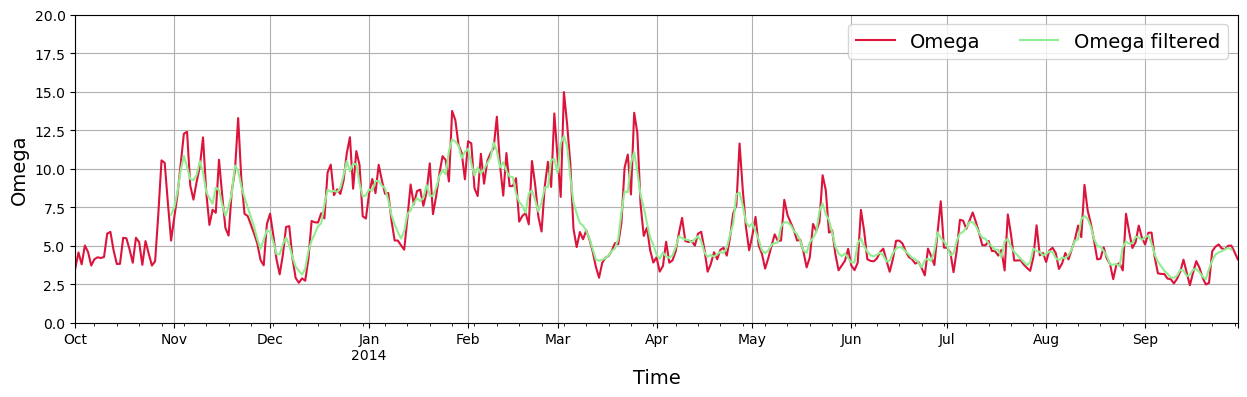

In [59]:
fig, ax = plt.subplots(figsize = [15, 4])
df_1_omega['Omega'].plot(ax = ax, label = 'Omega', color = 'crimson')
df_1_omegafiltered['omega_Filtered'].plot(ax = ax, label = 'Omega filtered', color = 'lightgreen')
ax.set_ylim([0, 20])
ax.legend(ncol = 2, fontsize = 14)
ax.grid()
ax.set_xlabel('Time', fontsize = 14)
ax.set_ylabel('Omega', fontsize = 14)

In [60]:
df_1_omegafiltered['month'] = df_1_omegafiltered.index.month # Date

### <font color='blue'>**PLOTS**</font>

<font color='purple'>**Omega (Ω)**</font>

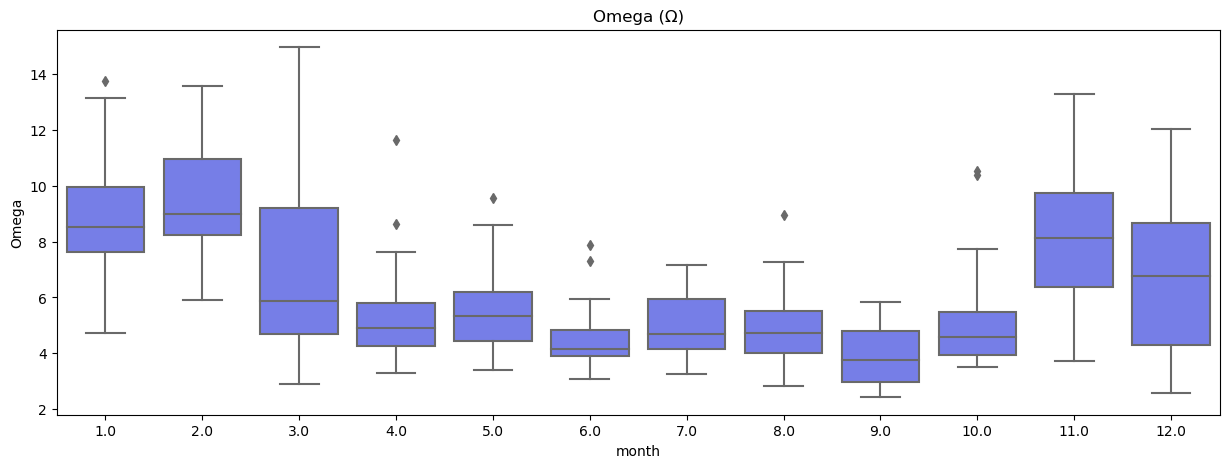

In [61]:
plt.figure(figsize=(15,5))
sns.boxplot(x="month", y="Omega", data= df_1, palette=[colors[0]])
plt.title('Omega (Ω)')
plt.show()

In [62]:
mean_omega_Filtered = df_1["Omega"].mean() # mean of Omega column
print('Mean Omega = '+str(mean_omega_Filtered.round(5))) # Print it!

Mean Omega = 6.1857


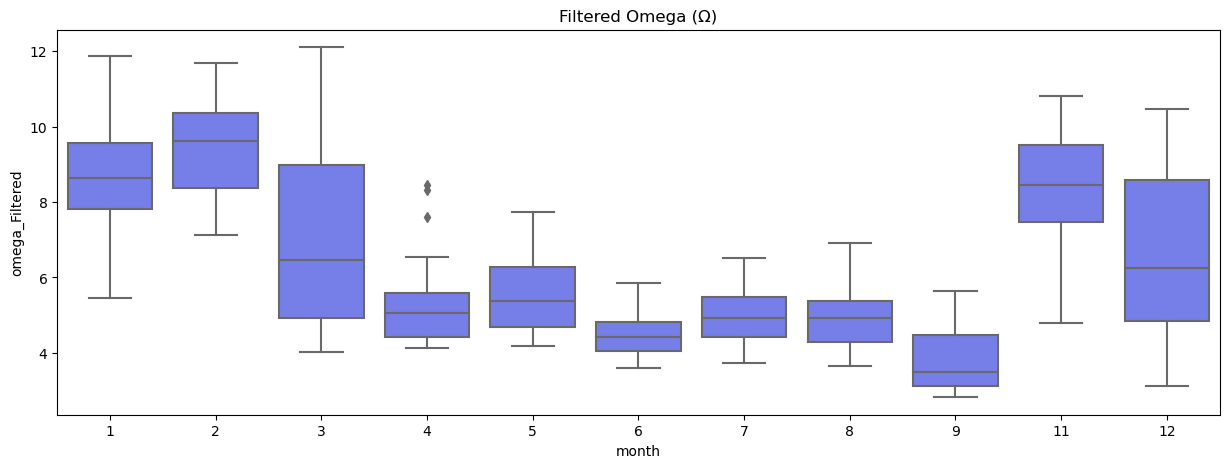

In [63]:
plt.figure(figsize=(15,5))
sns.boxplot(x="month", y="omega_Filtered", data=df_1_omegafiltered.iloc[1:-1], palette=[colors[0]])
plt.title('Filtered Omega (Ω)')
plt.show()

In [64]:
mean_omega_Filtered = df_1_omegafiltered["omega_Filtered"].mean() # mean of Omega column
print('Mean Omega = '+str(mean_omega_Filtered.round(5))) # Print it!

Mean Omega = 6.30429


<font color='purple'>**Monthly Beach State**</font>

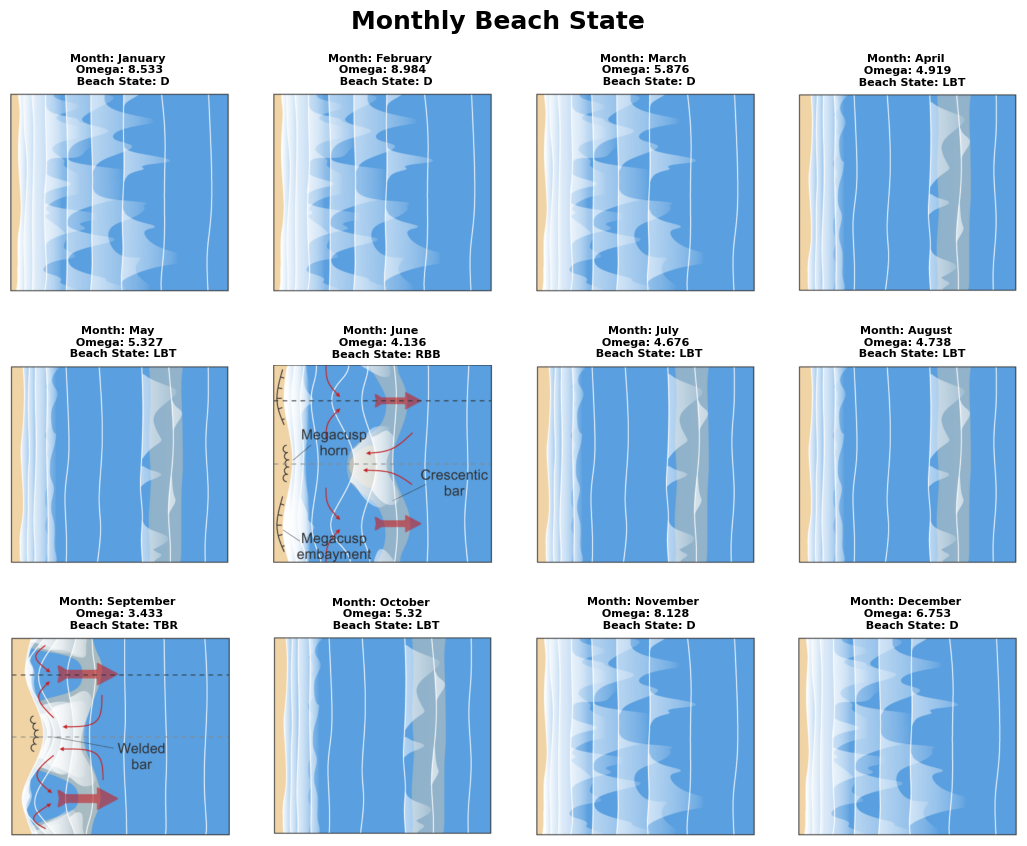

In [65]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import calendar 
from matplotlib import gridspec


umbrales = {
    "R": (0, 1.5),
    "LTT": (1.5, 2.5),

    
    "TBR": (2.5, 3.5),
    "RBB": (3.5, 4.5),
    "LBT": (4.5, 5.5),
    "D": (5.5, 50)
}


imagenes = {
    "R": "../images/Image_R.png",
    "LTT": "../images/Image_LTT.png",
    "TBR": "../images/Image_TBR.png",
    "RBB": "../images/Image_RBB.png",
    "LBT": "../images/Image_LBT.png",
    "D": "../images/Image_D.png"
}


medianas = []
etiquetas = []
rutas_imagenes = []
nombres_meses = []

for mes, mediana in df_1_omegafiltered.groupby('month')['Omega'].median().items():
    for etiqueta, (umbral_min, umbral_max) in umbrales.items():
        if umbral_min <= mediana <= umbral_max:

            mediana = round(mediana,3)
            
            medianas.append(mediana)
            etiquetas.append(etiqueta)
            rutas_imagenes.append(imagenes[etiqueta])
            nombres_meses.append(calendar.month_name[mes])  

            
df_result = pd.DataFrame({"Meses": nombres_meses, "Medianas": medianas, "Umbrales": etiquetas, "Imagen": rutas_imagenes})


fig = plt.figure(figsize=[13,10])
gs = gridspec.GridSpec(3,4) # hspace=0.1, wspace=0.5
plt.suptitle('Monthly Beach State', fontsize=18, color='k', fontweight="bold", y = 0.95)

for i, row in df_result.iterrows():
    ax = fig.add_subplot(gs[i])

    img = Image.open(row["Imagen"])

    ax.imshow(img)
    ax.set_title(f"Month: {row['Meses']} "+"\n"+f" Omega: {row['Medianas']} "+"\n"+f"  Beach State: {row['Umbrales']}", fontsize=8, color='k', fontweight="bold")
    ax.axis("off")

plt.show()

<font color='purple'>**Time Series**</font>

Text(0, 0.5, 'Omega_Filtered')

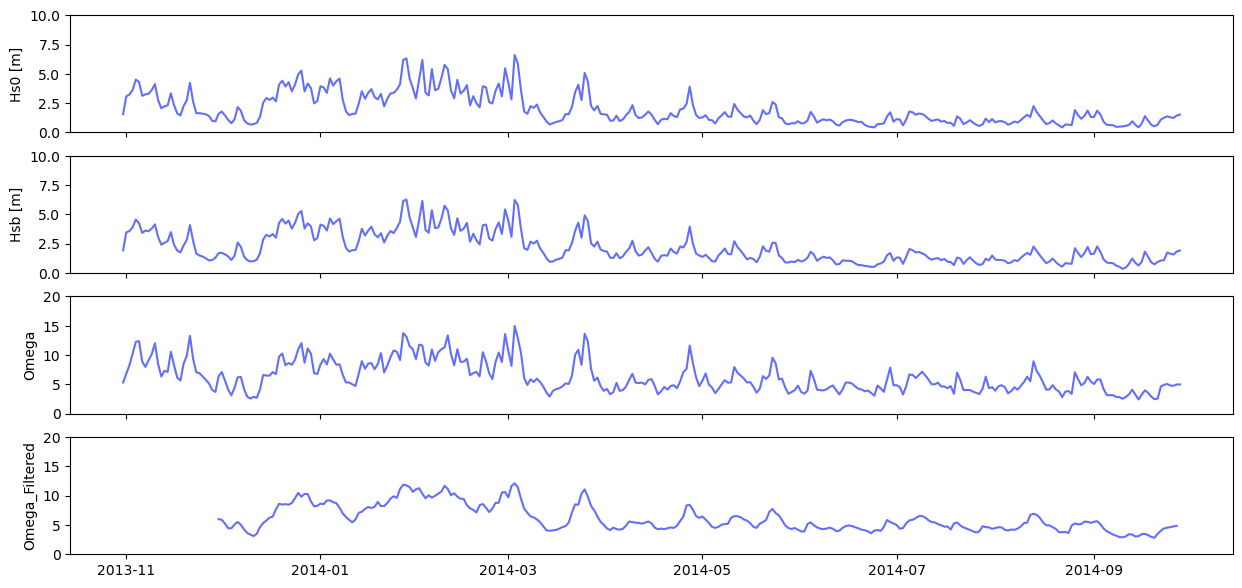

In [66]:
fig, axs = plt.subplots(4, sharex=True, figsize=(15,7))

axs[0].plot(df_1_omegafiltered.index, df_1_omegafiltered['swh'], c=colors[0])
axs[1].plot(df_1_omegafiltered.index, df_1_omegafiltered['H1_Goda_b'], c=colors[0])
axs[2].plot(df_1_omegafiltered.index, df_1_omegafiltered['Omega'], c=colors[0])
axs[3].plot(df_1_omegafiltered.iloc[30:-1].index, df_1_omegafiltered.iloc[30:-1]['omega_Filtered'], c=colors[0])

axs[0].set_ylim([0, 10])  
axs[1].set_ylim([0, 10])  
axs[2].set_ylim([0, 20]) 
axs[3].set_ylim([0, 20]) 

axs[0].set_ylabel('Hs0 [m]')
axs[1].set_ylabel('Hsb [m]')
axs[2].set_ylabel('Omega')
axs[3].set_ylabel('Omega_Filtered')

